In [24]:
import torch
import torch.nn as nn

In [25]:
class LayerNorm(nn.Module):
    def __init__(self, emd_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emd_dim))
        self.shift = nn.Parameter(torch.zeros(emd_dim))
    def forward(self, x):
        mean = x.mean(dim = -1, keepdim =True)
        var = x.var(dim =-1, keepdim = True, unbiased= False)
        norm_x = (x-mean)/(torch.sqrt(var+self.eps))
        return self.scale*norm_x + self.shift

In [26]:
batch_example = torch.rand(2,5)

In [27]:
lm = LayerNorm(5)
l_out = lm(batch_example)
print(l_out)

tensor([[-0.9631, -1.0142, -0.2754,  1.5897,  0.6630],
        [-0.2900,  1.3354, -1.4468,  0.8927, -0.4914]], grad_fn=<AddBackward0>)


In [28]:
print('mean: ', l_out.mean(dim=-1,keepdim=True))
print('Varaince: ', l_out.var(dim=-1,keepdim = True, unbiased = False))

mean:  tensor([[2.3842e-08],
        [1.1921e-07]], grad_fn=<MeanBackward1>)
Varaince:  tensor([[0.9998],
        [0.9998]], grad_fn=<VarBackward0>)


In [29]:
class GELU(nn.Module):
    def __init__(self,):
        super().__init__()
    def forward(self, x):
        return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.0447*torch.pow(x,3))))

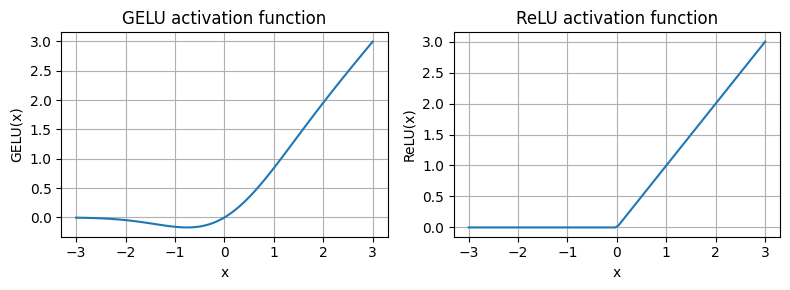

In [30]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# gpt-2 configurations
GPT_CONFIG_124= {
    'vocab_size' :50257,
    'context_length': 1024,
    'emb_dim':768,
    'n_heads':12,
    'n_layers':12,
    'drop_rate':0.1,
    'qkv_bias':False
}

In [32]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(cfg['emb_dim'], 4*cfg['emb_dim']), #incresing dimesion
                                    GELU(),
                                    nn.Linear(4*cfg['emb_dim'],cfg['emb_dim']))  #coming back to original dimension
    def forward(self,x):
        return self.layers(x)

In [33]:
GPT_CONFIG_124['emb_dim']

768

In [34]:
ffn = FeedForward(GPT_CONFIG_124)
x = torch.rand(2,3,768)
out = ffn(x)
print(out.shape)
print(out)

torch.Size([2, 3, 768])
tensor([[[ 0.0231,  0.2053,  0.0063,  ...,  0.0228, -0.0381,  0.0445],
         [ 0.2021,  0.0689,  0.0014,  ..., -0.0008, -0.1493,  0.1506],
         [-0.0093,  0.1084, -0.0271,  ..., -0.0362, -0.0991,  0.0183]],

        [[ 0.0317,  0.1987, -0.0030,  ..., -0.0745, -0.0584,  0.1274],
         [-0.0022,  0.1272, -0.0460,  ..., -0.1165,  0.0237,  0.0298],
         [ 0.1415,  0.2130, -0.0078,  ..., -0.0173, -0.0122,  0.0943]]],
       grad_fn=<ViewBackward0>)


## SHORTCUT CONNECTIONS

In [35]:
class ExampledeepNeuralnetwork(nn.Module):
    def __init__(self,layer_sizes,use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1],GELU())),
            nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2],GELU())),
            nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3],GELU())),
            nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4],GELU())),
            nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5],GELU())),
        ])
    def forward(self,x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape :
                x = x+layer_output 
            else:
                x = layer_output
        return x

In [36]:
layer_sizes  = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.,0.,-1.]])
torch.manual_seed(123)
model_without_shortcut = ExampledeepNeuralnetwork(layer_sizes=layer_sizes, use_shortcut=False)

In [37]:
print(model_without_shortcut)

ExampledeepNeuralnetwork(
  (layers): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=3, out_features=3, bias=True)
    )
    (4): Sequential(
      (0): Linear(in_features=3, out_features=1, bias=True)
    )
  )
)


In [38]:
# for printing gradient at each layer
def print_gradient(model,x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output,target)
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [39]:
print_gradient(model_without_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.0015313407639041543
layers.1.0.weight has gradient mean of 0.0008734685834497213
layers.2.0.weight has gradient mean of 0.002111609559506178
layers.3.0.weight has gradient mean of 0.0030934568494558334
layers.4.0.weight has gradient mean of 0.007880656979978085


In [40]:
model_with_shortcut = ExampledeepNeuralnetwork(layer_sizes=layer_sizes, use_shortcut=True)

In [41]:
print_gradient(model_with_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.24866612255573273
layers.1.0.weight has gradient mean of 0.8006524443626404
layers.2.0.weight has gradient mean of 0.3836198151111603
layers.3.0.weight has gradient mean of 0.3954206109046936
layers.4.0.weight has gradient mean of 1.001085877418518
